In [1]:
#%run -i read_counts.py
all_freqs = pickle.load(open('all_freqs.pkl', 'rb'))

In [2]:
from matplotlib import pyplot as plt

%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

import pandas as pd
pd.options.display.mpl_style = 'default'

from mpltools import style
from mpltools import layout

style.use('ggplot')

## see: https://stackoverflow.com/questions/19536817/manipulate-html-module-font-size-in-ipython-notebook
class sizeme():
    """ Class to change html fontsize of object's representation"""
    def __init__(self,ob, size, height=100):
        self.ob = ob
        self.size = size
        self.height = height
    def _repr_html_(self):
        repl_tuple = (self.size, self.height, self.ob._repr_html_())
        return u'<span style="font-size:{0}%; line-height:{1}%">{2}</span>'.format(*repl_tuple)
    
## see https://stackoverflow.com/questions/14656852/how-to-use-pandas-dataframes-and-numpy-arrays-in-rpy2
## and http://ipython.org/ipython-doc/rel-0.13/config/extensions/rmagic.html
## note there's a ri2pandas() to convert back.
## but note, rpy2 2.4.0 and later automagically translates dataframes: 
## https://stackoverflow.com/questions/20630121/pandas-how-to-convert-r-dataframe-back-to-pandas
%load_ext rpy2.ipython
#import rpy2.robjects.pandas2ri as p2r
#rdf = p2r.pandas2ri(info)
#%Rpush rdf

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [3]:
x = all_freqs['Desulfovibrio_vulgaris_Hildenborough_uid57645'].copy()
sample_info = pd.read_excel('Sample_Info_COMPLETE.xlsx') ##,skiprows=[0])
sample_info = sample_info.set_index( sample_info['Sample name'] )
sample_infos = { k:sample_info.ix[all_freqs[k].columns.droplevel(1).values] for k in all_freqs.keys() }
info = sample_infos['Desulfovibrio_vulgaris_Hildenborough_uid57645'].copy()
sizeme(info.head(3),50,120)

,Sample name,Source,Barcode,Strain/condition,cultivation type,Chemostat/batch ID #,Description/condition details,Description/condition details -2,carbon source,electron donor,concentration (mM),electron acceptor,growth rate per h,T0C,organisms
Sample name,,,,,,,,,,,,,,,
Sample_US-1505885,Sample_US-1505885,Labcorp,US-1505885,PS 37 C log 2,batch,NaN,"pyruvate 80mM, sulfate 15mM 37C",sulfate respiration/growth,pyruvate 80mM,pyruvate,NaN,sulfate,NaN,37,D vulgaris Hildenborugh
Sample_US-1505888,Sample_US-1505888,Labcorp,US-1505888,LS 37C log 1,batch,NaN,"lactate 40mM, sulfate15mM 37C",sulfate respiration/growth,lactate 40mM,lactate,NaN,sulfate,NaN,37,D vulgaris Hildenborugh
Sample_US-1505895,Sample_US-1505895,Labcorp,US-1505895,LS 37C e. stat 1,batch,NaN,"lactate 40mM, sulfate15mM 37C",fermentation,lactate 10mM,lactate,10,none,0,37,D vulgaris Hildenborugh


In [5]:
%Rpush info
%Rpush x
genes = x.index.values.astype('str')
print(genes)
%Rpush genes
#%R save.image("Untitled1.RData")

['DVU0001' 'DVU0002' 'DVU0003' ..., '__too_low_aQual' '__not_aligned'
 '__alignment_not_unique']


In [6]:
%%R
#    load("Untitled1.RData")
    good_gene = which(!substr(genes,1,2)=='__' & apply(x,1,sum)>0)
    x = x[good_gene,]
    rownames(x)=genes[good_gene]
    x.orig = x = as.matrix(x); NULL

NULL


##### Note I now think that we have to use all genes and use the non-centered-scaled data (ranked?) to do good classification.

### Train classifier on growth rate

In [ ]:
%%R
require(Boruta)
doMC:::registerDoMC(cores=8)

gr=info$growth.rate.per.h; gr=as.numeric(as.character(gr)); gr[is.na(gr)]=0.2
Y <- factor( ifelse(gr==0, 'no_growth', ifelse(gr>=0.2, 'fast_growth', 'med_growth')) )

B.gr1 <- Boruta(t(x), Y, getImp=getImpFerns, ferns=10000, doTrace=0)
B.gr2 <- Boruta(t(x), Y, getImp=getImpRfZ, ntree=10000, doTrace=0)
NULL;

In [ ]:
%%R
print(B.gr1)
print(B.gr1$finalDecision[B.gr1$finalDecision=='Confirmed'])
print(' ')
print(B.gr2)
print(B.gr2$finalDecision[B.gr2$finalDecision=='Confirmed'])
NULL;

In [49]:
%R imp_vars = names(B.gr1$finalDecision[B.gr1$finalDecision=='Confirmed'])
%Rpull imp_vars

query = '%22'+'%22+%22'.join(imp_vars)+'%22'
print ' '.join(imp_vars)
print 'http://networks.systemsbiology.net/search?q='+query
from IPython.display import IFrame
IFrame('http://networks.systemsbiology.net/search?q='+query, width='100%', height=250)

DVU0033 DVU0146 DVU0147 DVU0148 DVU0149 DVU0150 DVU0152 DVU0169 DVU0267 DVU0277 DVU0305 DVU0378 DVU0471 DVU0501 DVU0503 DVU0530 DVU0532 DVU0536 DVU0549 DVU0566 DVU0576 DVU0585 DVU0598 DVU0599 DVU0684 DVU0692 DVU0701 DVU0707 DVU0794 DVU0799 DVU0808 DVU0810 DVU0879 DVU0920 DVU0936 DVU0967 DVU1037 DVU1060 DVU1069 DVU1109 DVU1236 DVU1257 DVU1258 DVU1349 DVU1365 DVU1368 DVU1412 DVU1470 DVU1537 DVU1548 DVU1559 DVU1621 DVU1655 DVU1786 DVU1790 DVU1840 DVU1841 DVU1873 DVU1891 DVU1912 DVU1936 DVU1950 DVU1964 DVU1971 DVU2069 DVU2105 DVU2107 DVU2108 DVU2110 DVU2130 DVU2135 DVU2235 DVU2251 DVU2256 DVU2286 DVU2287 DVU2289 DVU2290 DVU2291 DVU2292 DVU2294 DVU2298 DVU2299 DVU2300 DVU2350 DVU2383 DVU2424 DVU2451 DVU2472 DVU2569 DVU2974 DVU2975 DVU2983 DVU2984 DVU2985 DVU3025 DVU3026 DVU3027 DVU3028 DVU3029 DVU3030 DVU3031 DVU3032 DVU3033 DVU3069 DVU3083 DVU3084 DVU3132 DVU3133 DVU3134 DVU3148 DVU3161 DVU3211 DVU3217 DVU3234 DVU3270 DVU3307 DVU3308 DVU_tRNA.Thr.3 Dv23SA Dv23SB Dv23SD
http://networks.syst

### Train classifier on electron donor

In [32]:
%%R
Y <- info$electron.donor
B.ed1 <- Boruta(t(x), Y, getImp=getImpFerns, ferns=10000, doTrace=0)
B.ed2 <- Boruta(t(x), Y, getImp=getImpRfZ, ntree=10000, doTrace=0)
NULL;

NULL


In [ ]:
%%R
print(B.ed1)
print(B.ed1$finalDecision[B.ed1$finalDecision=='Confirmed'])
print('')
print(B.ed2)
print(B.ed2$finalDecision[B.ed2$finalDecision=='Confirmed'])
NULL

In [48]:
%R imp_vars = names(B.ed1$finalDecision[B.ed1$finalDecision=='Confirmed'])
%Rpull imp_vars

query = '%22'+'%22+%22'.join(imp_vars)+'%22'
print ' '.join(imp_vars)
print 'http://networks.systemsbiology.net/search?q='+query
from IPython.display import IFrame
IFrame('http://networks.systemsbiology.net/search?q='+query, width='100%', height=250)

DVU0007 DVU0019 DVU0028 DVU0029 DVU0031 DVU0036 DVU0040 DVU0041 DVU0042 DVU0053 DVU0072 DVU0073 DVU0139 DVU0146 DVU0148 DVU0149 DVU0150 DVU0169 DVU0180 DVU0286 DVU0333 DVU0334 DVU0359 DVU0392 DVU0413 DVU0415 DVU0425 DVU0429 DVU0430 DVU0431 DVU0432 DVU0433 DVU0434 DVU0496 DVU0515 DVU0520 DVU0532 DVU0535 DVU0536 DVU0547 DVU0549 DVU0550 DVU0582 DVU0613 DVU0614 DVU0617 DVU0648 DVU0649 DVU0654 DVU0658 DVU0662 DVU0677 DVU0682 DVU0712 DVU0741 DVU0742 DVU0745 DVU0767 DVU0773 DVU0801 DVU0819 DVU0845 DVU0846 DVU0847 DVU0848 DVU0849 DVU0850 DVU0851 DVU0881 DVU0890 DVU0900 DVU0920 DVU0979 DVU0981 DVU0987 DVU1012 DVU1032 DVU1073 DVU1109 DVU1121 DVU1180 DVU1187 DVU1203 DVU1295 DVU1296 DVU1341 DVU1363 DVU1376 DVU1396 DVU1404 DVU1407 DVU1411 DVU1441 DVU1442 DVU1444 DVU1481 DVU1488 DVU1524 DVU1545 DVU1569 DVU1613 DVU1614 DVU1636 DVU1669 DVU1670 DVU1674 DVU1822 DVU1877 DVU1917 DVU1923 DVU1932 DVU1990 DVU2091 DVU2092 DVU2093 DVU2094 DVU2095 DVU2105 DVU2139 DVU2141 DVU2142 DVU2204 DVU2285 DVU2286 DVU2287 

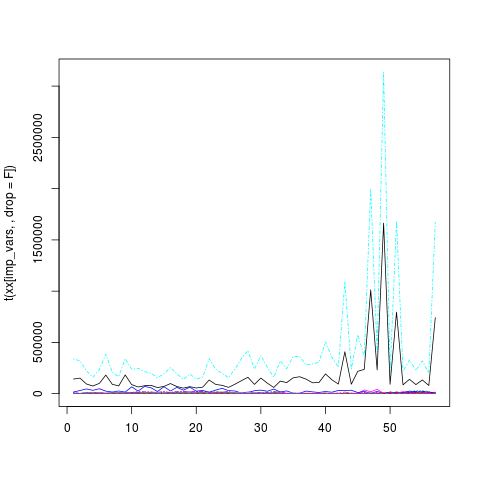

In [35]:
%R xx=cbind(x[,Y=='lactate'],x[,Y=='pyruvate'],x[,Y=='hydrogen']); matplot(t(xx[imp_vars,,drop=F]),typ='l')
#%R xx=cbind(x.orig[,Y=='lactate'],x.orig[,Y=='pyruvate'],x.orig[,Y=='hydrogen']); matplot(t(xx[imp_vars,,drop=F]),typ='l')

### Train classifier on electron acceptor

In [36]:
%%R
Y <- info$electron.acceptor
B.ea1 <- Boruta(t(x), Y, getImp=getImpFerns, ferns=10000, doTrace=0)
B.ea2 <- Boruta(t(x), Y, getImp=getImpRfZ, ntree=10000, doTrace=0)
NULL;

NULL


In [ ]:
%%R
print(B.ea1)
print(B.ea1$finalDecision[B.ea1$finalDecision=='Confirmed'])
print('')
print(B.ea2)
print(B.ea2$finalDecision[B.ea2$finalDecision=='Confirmed'])
NULL

In [47]:
%R imp_vars = names(B.ea1$finalDecision[B.ea1$finalDecision=='Confirmed'])
%Rpull imp_vars

query = '%22'+'%22+%22'.join(imp_vars)+'%22'
print ' '.join(imp_vars)
print 'http://networks.systemsbiology.net/search?q='+query
from IPython.display import IFrame
IFrame('http://networks.systemsbiology.net/search?q='+query, width='100%', height=250)

DVU0034 DVU0053 DVU0056 DVU0060 DVU0085 DVU0139 DVU0140 DVU0145 DVU0146 DVU0147 DVU0148 DVU0149 DVU0150 DVU0152 DVU0161 DVU0162 DVU0170 DVU0172 DVU0173 DVU0186 DVU0240 DVU0253 DVU0259 DVU0260 DVU0261 DVU0262 DVU0263 DVU0264 DVU0265 DVU0266 DVU0267 DVU0269 DVU0270 DVU0271 DVU0273 DVU0295 DVU0304 DVU0305 DVU0307 DVU0309 DVU0311 DVU0312 DVU0313 DVU0314 DVU0315 DVU0316 DVU0317 DVU0318 DVU0320 DVU0322 DVU0331 DVU0367 DVU0378 DVU0401 DVU0409 DVU0410 DVU0423 DVU0425 DVU0429 DVU0430 DVU0431 DVU0432 DVU0433 DVU0434 DVU0441 DVU0486 DVU0501 DVU0504 DVU0505 DVU0512 DVU0513 DVU0514 DVU0515 DVU0517 DVU0518 DVU0519 DVU0520 DVU0523 DVU0524 DVU0529 DVU0530 DVU0531 DVU0532 DVU0533 DVU0534 DVU0535 DVU0536 DVU0549 DVU0550 DVU0586 DVU0587 DVU0588 DVU0591 DVU0592 DVU0594 DVU0595 DVU0607 DVU0614 DVU0616 DVU0617 DVU0668 DVU0675 DVU0683 DVU0700 DVU0713 DVU0715 DVU0716 DVU0752 DVU0763 DVU0799 DVU0835 DVU0836 DVU0837 DVU0838 DVU0839 DVU0858 DVU0862 DVU0863 DVU0879 DVU0880 DVU0920 DVU0927 DVU0928 DVU0936 DVU0951 

### Train classifier on temperature

In [ ]:
%%R
Y <- as.factor(as.character(info$T0C == 37))
B.temp1 <- Boruta(t(x), Y, getImp=getImpFerns, ferns=10000, doTrace=0)
B.temp2 <- Boruta(t(x), Y, getImp=getImpRfZ, ntree=10000, doTrace=0)
NULL;

In [ ]:
%%R
print(B.temp1)
print(B.temp1$finalDecision[B.temp1$finalDecision=='Confirmed'])
print('')
print(B.temp2)
print(B.temp2$finalDecision[B.temp2$finalDecision=='Confirmed'])
NULL

In [46]:
%R imp_vars = names(B.temp1$finalDecision[B.temp1$finalDecision=='Confirmed'])
%Rpull imp_vars

query = '%22'+'%22+%22'.join(imp_vars)+'%22'
print ' '.join(imp_vars)
print 'http://networks.systemsbiology.net/search?q='+query
from IPython.display import IFrame
IFrame('http://networks.systemsbiology.net/search?q='+query, width='100%', height=250)

DVU0041 DVU0052 DVU0087 DVU0090 DVU0093 DVU0107 DVU0175 DVU0193 DVU0200 DVU0202 DVU0210 DVU0213 DVU0225 DVU0241 DVU0259 DVU0260 DVU0261 DVU0262 DVU0263 DVU0264 DVU0265 DVU0266 DVU0284 DVU0318 DVU0418 DVU0498 DVU0525 DVU0526 DVU0577 DVU0664 DVU0677 DVU0682 DVU0702 DVU0805 DVU0806 DVU0834 DVU0854 DVU0857 DVU0870 DVU0936 DVU0966 DVU0978 DVU0995 DVU1029 DVU1120 DVU1209 DVU1337 DVU1392 DVU1434 DVU1455 DVU1480 DVU1491 DVU1529 DVU1530 DVU1704 DVU1795 DVU1801 DVU1820 DVU1826 DVU1937 DVU2076 DVU2200 DVU2212 DVU2233 DVU2514 DVU2554 DVU2555 DVU2558 DVU2683 DVU2720 DVU2735 DVU2774 DVU2856 DVU2859 DVU2869 DVU2874 DVU2903 DVU2925 DVU2927 DVU2939 DVU2944 DVU3002 DVU3065 DVU3097 DVU3128 DVU3130 DVU3131 DVU3132 DVU3133 DVU3135 DVU3162 DVU3183 DVU3184 DVU3212 DVU3242 DVU3272 DVU3281 DVU3298 DVU3299 DVU3300 DVU3301 DVU3309 DvtmRNA1
http://networks.systemsbiology.net/search?q=%22DVU0041%22+%22DVU0052%22+%22DVU0087%22+%22DVU0090%22+%22DVU0093%22+%22DVU0107%22+%22DVU0175%22+%22DVU0193%22+%22DVU0200%22+%22DV